#Setting Up Colab and Installing required Libraries




In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Setup colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import warnings 
warnings.filterwarnings("ignore")


In [0]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import sparse

# Fetching Required files from Drive


In [0]:
id='1FRjhOrgx64gEvp2rPPDiZo-UzEgSfnPG'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('songs.csv')
#https://drive.google.com/open?id=1-j7cQdaYC49se3zo2LP6zo0m8bq6vUyK

#https://drive.google.com/open?id=1-j7cQdaYC49se3zo2LP6zo0m8bq6vUyK
#https://drive.google.com/open?id=1FRjhOrgx64gEvp2rPPDiZo-UzEgSfnPG

In [0]:
df_songs_raw = pd.read_csv('songs.csv')
df_songs_raw.head(2)

,name,track uri,artist,followers,artist_popularity,release_date,lyrics,duration_ms,song_popularity,explicit,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Playlist_Name,listener_count,filtered_lyrics,Topic0,Topic1,Topic2,Topic3,dominant_topic,sentiment
0,God Is Dead?,spotify:track:42wFRybIJ2n5RoD7r9R8Rz,Black Sabbath,4027757,77,1/1/2013,Lost in the darkness\nI fade from the light\nF...,532266,2,False,0.000187,0.378,0.733,0.00195,0.0582,-4.935,0.0331,118.454,0.164,Top 100 Metal Tracks on Spotify,139370.0,lost darkness fade light faith father brother ...,0.0,0.94,0.0,0.06,1,-0.9951
1,The Enemy Inside,spotify:track:1ZR4QAYsiO9zPsGaMPW2OI,Dream Theater,941336,68,9/16/2013,Over and over again\nI relive the moment\nI'm ...,377373,52,False,0.000012,0.488,0.976,0.02950,0.0670,-4.165,0.1420,143.988,0.404,Top 100 Metal Tracks on Spotify,72344.0,relive moment bearing burden within open wound...,0.0,0.49,0.0,0.50,3,-0.9962


In [0]:
# Dropping the duplicates of songs in the dataframe
print(df_songs_raw.shape)
df_songs=df_songs_raw.drop_duplicates(subset='name', keep='first', inplace=False)
df_songs.shape

(2977, 28)


(2857, 28)

#Clustering Around Song Features

In [0]:
#Creating a new DF for song Clusters - 'instrumentalness' was removed, becauase of variation and 0's
df_mod = df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
print(df_mod.mean(), df_mod.std())

acousticness      0.227866
danceability      0.606598
energy            0.649814
liveness          0.185514
loudness         -6.780174
speechiness       0.102664
tempo           122.339866
valence           0.455279
dtype: float64 acousticness     0.282818
danceability     0.160425
energy           0.210438
liveness         0.147436
loudness         3.194067
speechiness      0.105042
tempo           29.131761
valence          0.225162
dtype: float64


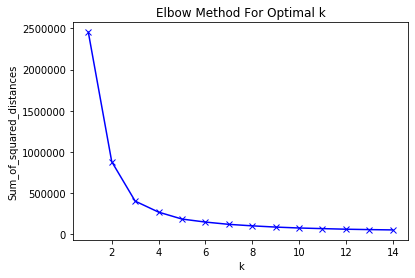

In [0]:
#Testing diff 'k' values for clustering
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_mod)
    Sum_of_squared_distances.append(km.inertia_)

# Elbow plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

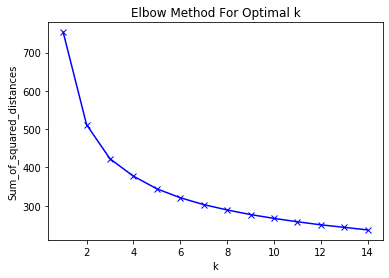

In [0]:
#Min-max transform before clustering
mms = MinMaxScaler()
mms.fit(df_mod)
data_transformed = mms.transform(df_mod)

#Testing diff 'k' values for clustering
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

# Elbow plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
best_cluster = KMeans(n_clusters=4)
best_cluster = best_cluster.fit(df_mod)
cluster=list(best_cluster.labels_)

cluster_dict={}
for i in cluster:
  if i in cluster_dict.keys():
    cluster_dict[i]=cluster_dict[i]+1
  else:
    cluster_dict[i]=1
cluster_dict

{0: 647, 1: 877, 2: 984, 3: 349}

#Declaring Y-variable and Predictive Model


In [0]:
Y_median = df_songs['song_popularity'].median()
def Y_creator(score):
    if score > 70000:
        return 1
    else:
        return 0
df_songs['Hit']=df_songs['listener_count'].apply(Y_creator)
df_songs.head(2)
df_songs.Hit.value_counts()

0    1964
1     893
Name: Hit, dtype: int64

##Logistic Regression on Music Features only


In [0]:
df_features = df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
X = df_features
y = df_songs[['Hit']]

In [0]:


#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

#Prediction Accuracy and Confusion Matrix
print("The accuracy of the model is ",round(log_reg.score(x_test, y_test),2))
predictions = log_reg.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)

The accuracy of the model is  0.69


predicted,0
actual,
0,490
1,225


##Logistic Regression on Music Features and Artist Popularity


In [0]:
X2=df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','artist_popularity']]

#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

#Prediction Accuracy and Confusion Matrix
print("The accuracy of the model is ",round(log_reg.score(x_test, y_test),2))
predictions = log_reg.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)

The accuracy of the model is  0.76


predicted,0,1
actual,,
0,451,39
1,136,89


#Prediction with Topic Modelling and sentiment

In [0]:
X2=df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','Topic0','Topic1','Topic2','Topic3','sentiment']]

#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

#Prediction Accuracy and Confusion Matrix
print("The accuracy of the model is ",round(log_reg.score(x_test, y_test),2))
predictions = log_reg.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)

The accuracy of the model is  0.68


predicted,0,1
actual,,
0,480,10
1,216,9


#TF-IDF Creation for Lyrics

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
cv=CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2), stop_words='english', max_features=1250)
word_count_vector=cv.fit_transform(df_songs.lyrics.values)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(word_count_vector)

In [0]:
X3=tf_idf_vector

#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X3, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

#Prediction Accuracy and Confusion Matrix
print("The accuracy of the model is ",round(log_reg.score(x_test, y_test),2))
predictions = log_reg.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)

The accuracy of the model is  0.7


predicted,0,1
actual,,
0,456,34
1,180,45


In [0]:

combined = sparse.hstack([tf_idf_vector, sparse.csr_matrix(X2)])
X4 = combined
#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X4, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

#Prediction Accuracy and Confusion Matrix
print("The accuracy of the model is ",round(log_reg.score(x_test, y_test),2))
predictions = log_reg.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)

The accuracy of the model is  0.71


predicted,0,1
actual,,
0,448,42
1,166,59


# Random Forest


In [0]:
X1=df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]

#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(max_depth=8, random_state=0,n_estimators=1000)
regr.fit(x_train, y_train)
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
r2_score(y_train, regr.predict(x_train), sample_weight=None)


print(accuracy_score(y_test, regr.predict(x_test).round(), sample_weight=None))

predictions = regr.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)

0.6895104895104895


predicted,0,1
actual,,
0,476,14
1,208,17


In [0]:
X2=df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','Topic0','Topic1','Topic2','Topic3','sentiment']]
combined = sparse.hstack([tf_idf_vector, sparse.csr_matrix(X2)])
X4 = combined
#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X4, y, test_size=0.25, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(max_depth=8, random_state=0,n_estimators=1000)
regr.fit(x_train, y_train)
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
r2_score(y_train, regr.predict(x_train), sample_weight=None)


accuracy_score(y_test, regr.predict(x_test).round(), sample_weight=None)


print(accuracy_score(y_test, regr.predict(x_test).round(), sample_weight=None))

predictions = regr.predict(x_test)
confusion = pd.DataFrame(zip(y_test.Hit, predictions), columns=['actual', 'predicted'])
pd.crosstab(confusion.actual, confusion.predicted)


0.6825174825174826


predicted,0,1
actual,,
0,487,3
1,224,1


#Topic Modelling 


In [0]:
import re
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
# stop_words.append('yeah')
print(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<WordListCorpusReader in '/root/nltk_data/corpora/stopwords'>


In [0]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
final_lyrics = []
df_songs['filtered_lyrics'] = ''
stop_words.append("'re")
try:
  for each in range(len(df_songs)):
    cleaned_lyrics = (re.sub(r"[,.:;?'\")(!]\d", ' ', str(df_songs.loc[each,'lyrics']))).lower()
    lemmatized_lyrics = lemmatizer.lemmatize(cleaned_lyrics)
    tokenized_lyrics = word_tokenize(lemmatized_lyrics)
    filtered_lyrics = [w for w in tokenized_lyrics if not w in stop_words]
    filtered_lyrics = [w for w in filtered_lyrics if len(w) > 2]
    final_lyrics.append(filtered_lyrics)
    filtered_lyrics = ' '.join(filtered_lyrics)
    df_songs.loc[each, 'filtered_lyrics'] = filtered_lyrics
except:
  pass

df_songs[['lyrics','filtered_lyrics']][130:150]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,lyrics,filtered_lyrics
130,"Mmm… Buh, buh, buh, buh, buh, buh, buh-duh-dah...",mmm… buh buh buh buh buh buh buh-duh-dah duh d...
131,It's like an intuition or a feeling in the air...,like intuition feeling air intangible impressi...
132,I guess I\nThought we were indivisible\nRememb...,guess thought indivisible remember distance n'...
133,We're smashing mics in karaoke bars\nYou're ru...,smashing mics karaoke bars running late half m...
134,"Once upon a time, a few mistakes ago\nI was in...",upon time mistakes ago sights got alone found ...
135,Well the comedown here was easy\nLike the arri...,well comedown easy like arrival new day dream ...
136,"""Oh, don't you dare look back\nJust keep your ...",n't dare look back keep eyes said holding back...
137,"I've held it in my hands, I've held it in my h...",'ve held hands 've held hands dismembered soul...
138,Stuck in the shade\nWhere there's no sunshine\...,stuck shade sunshine n't wan play kids sun sin...
139,"When you reach it, you gaze an age\nSeldom pla...",reach gaze age seldom place word getting shape...


In [0]:
dictionary = gensim.corpora.Dictionary(final_lyrics)
dictionary.filter_extremes(no_below=1, no_above=0.5)

bow_corpus = [dictionary.doc2bow(label) for label in final_lyrics]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary\
                                       , passes=2, workers=2, chunksize=100, random_state=3)

lda_model.print_topics()

[(0,
  '0.029*"get" + 0.018*"got" + 0.017*"first" + 0.017*"scarecrow" + 0.017*"one" + 0.014*"light" + 0.013*"wan" + 0.013*"know" + 0.010*"burning" + 0.009*"guess"'),
 (1,
  '0.048*"take" + 0.044*"gon" + 0.027*"gunman" + 0.018*"bit" + 0.018*"camera" + 0.015*"knees" + 0.013*"eyes" + 0.010*"need" + 0.009*"fight" + 0.009*"run"'),
 (2,
  '0.011*"one" + 0.008*"\'ll" + 0.008*"love" + 0.007*"yeah" + 0.006*"never" + 0.005*"got" + 0.004*"make" + 0.004*"lot" + 0.004*"say" + 0.004*"life"'),
 (3,
  '0.012*"yeah" + 0.007*"got" + 0.006*"one" + 0.006*"know" + 0.006*"want" + 0.006*"back" + 0.005*"\'ve" + 0.005*"night" + 0.005*"see" + 0.004*"love"')]

In [0]:
df_topics = df_songs

df_topics['topic_0'] = 0.0
df_topics['topic_1'] = 0.0
df_topics['topic_2'] = 0.0
df_topics['topic_3'] = 0.0

In [0]:
count = 0
for index, row in df_topics.iterrows():
    try:
      bow = dictionary.doc2bow(final_lyrics[index])
      t = lda_model.get_document_topics(bow)
      df_topics['topic_0'].loc[index] = t[0][1]
      df_topics['topic_1'].loc[index] = t[1][1]
      df_topics['topic_2'].loc[index] = t[2][1]
      df_topics['topic_3'].loc[index] = t[3][1]
    except:
      pass

df_topics.head(10)

,name,track uri,artist,followers,artist_popularity,release_date,lyrics,duration_ms,song_popularity,explicit,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Playlist_Name,listener_count,filtered_lyrics,Topic0,Topic1,Topic2,Topic3,dominant_topic,sentiment,Hit,topic_0,topic_1,topic_2,topic_3
0,God Is Dead?,spotify:track:42wFRybIJ2n5RoD7r9R8Rz,Black Sabbath,4027757,77,1/1/2013,Lost in the darkness\nI fade from the light\nF...,532266,2,False,0.000187,0.378,0.733,0.001950,0.0582,-4.935,0.0331,118.454,0.164,Top 100 Metal Tracks on Spotify,139370.0,lost darkness fade light faith father brother ...,0.00,0.94,0.00,0.06,1,-0.9951,1,0.995083,0.000000,0.000000,0.000000
1,The Enemy Inside,spotify:track:1ZR4QAYsiO9zPsGaMPW2OI,Dream Theater,941336,68,9/16/2013,Over and over again\nI relive the moment\nI'm ...,377373,52,False,0.000012,0.488,0.976,0.029500,0.0670,-4.165,0.1420,143.988,0.404,Top 100 Metal Tracks on Spotify,72344.0,relive moment bearing burden within open wound...,0.00,0.49,0.00,0.50,3,-0.9962,1,0.992551,0.000000,0.000000,0.000000
2,Temper Temper,spotify:track:2weyHZ3Rk4PZVZODz1asqz,Bullet For My Valentine,1767902,73,2/8/2013,This time you'd better bite your tongue\nThink...,188866,49,False,0.001560,0.439,0.987,0.000016,0.4240,-3.576,0.2200,163.393,0.378,Top 100 Metal Tracks on Spotify,58497.0,time better bite tongue think twice open mouth...,0.00,0.22,0.33,0.45,3,-0.9970,0,0.732357,0.064657,0.201336,0.000000
3,Heartbreaker,spotify:track:7GwtlmQVrqyoggPraFXXvJ,Motörhead,1966405,70,10/18/2013,Careful where you stand now boy\nEverything ha...,185016,41,False,0.000103,0.452,0.995,0.359000,0.2040,-3.958,0.0752,100.043,0.237,Top 100 Metal Tracks on Spotify,47733.0,careful stand boy everything changed got searc...,0.00,0.56,0.07,0.37,1,-0.9947,0,0.316445,0.048767,0.206367,0.428421
4,End Of The Beginning,spotify:track:4ZDRzrXIW3EdC5FR0HGi3v,Black Sabbath,4027757,77,1/1/2013,Is this the end of the beginning\nOr the begin...,486226,0,False,0.000083,0.309,0.882,0.107000,0.0976,-4.054,0.0629,123.558,0.174,Top 100 Metal Tracks on Spotify,111701.0,end beginning beginning end losing control win...,0.00,0.32,0.09,0.59,3,0.9807,1,0.541306,0.176790,0.279262,0.000000
5,Breaking Point,spotify:track:5duR1jvJ2E0IOoYresQIkQ,Bullet For My Valentine,1767902,73,2/8/2013,Spinning out mind (poison)\nThat's headache ta...,222453,48,False,0.000485,0.319,0.967,0.000103,0.3150,-3.485,0.1240,147.947,0.269,Top 100 Metal Tracks on Spotify,52012.0,spinning mind poison headache taste tip tongue...,0.00,0.87,0.00,0.12,1,-0.9569,0,0.353509,0.641822,0.000000,0.000000
6,Yesterday Don't Mean Shit,spotify:track:4W4g7CnyIJbz3sDyNNMZ8z,Pantera,2352736,72,8/30/2013,There's nothing special about it \nIt's either...,259693,22,True,0.000033,0.347,0.991,0.100000,0.3140,-2.444,0.1600,146.478,0.449,Top 100 Metal Tracks on Spotify,58148.0,nothing special either born gifted talent big ...,0.32,0.50,0.18,0.00,1,0.9480,0,0.993249,0.000000,0.000000,0.000000
7,The Looking Glass,spotify:track:5l79BZlSp7p8rBiUAvtTLI,Dream Theater,941336,68,9/16/2013,I would not expect you felt unnoticed and igno...,293066,42,False,0.000037,0.518,0.960,0.000026,0.2190,-3.972,0.0661,137.980,0.598,Top 100 Metal Tracks on Spotify,49209.0,would expect felt unnoticed ignored better ris...,0.00,0.99,0.00,0.00,1,0.9857,0,0.992329,0.000000,0.000000,0.000000
8,Ride the Lightning (Live),spotify:track:1w3r4q8rgcc2WVHZPUuEnO,Metallica,12406259,85,2013,"Guilty as charged but damn it, it ain't right\...",414306,33,False,0.000105,0.277,0.933,0.105000,0.9520,-8.073,0.0565,153.551,0.366,Top 100 Metal Tracks on Spotify,30691.0,guilty charged damn n't right someone else con...,0.00,0.99,0.00,0.00,1,-0.9796,0,0.497883,0.114937,0.282290,0.104890
9,Coup de Grace,spotify:track:0ibDhZncUAEjILJJlTUQpS,Motörhead,1966405,70,10/18/2013,Make it quick\nThe Coup de Grace\nMakes you de...,225464,29,False,0.000332,0.409,0.988,0.003670,0.2790,-4.388,0.0533,94.028,0.357,Top 100 Metal Tracks on 

#Recommendation System


In [0]:
# from scipy.spatial.distance import cosine

# s = "This concept of distance is not restricted to two dimensions."
# list_s = ["It is not difficult to imagine the figure above translated into three dimensions.", "We can persuade ourselves that the measure of distance extends to an arbitrary number of dimensions;"]

# X = tfidf.fit_transform([s] + list_s)

# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True,tokenizer=LemmaTokenizer())
# bow_matrix = tfidf.fit_transform([s, ' '.join(list_s)])

# cosine(X[0].toarray(), X[1].toarray()) # cosine between s and 1st sentence

# # print(X)
# # print(type(X))
# # print(type(combined))
# # print(combined)

In [0]:
documents = (
"The sky is blue",
"The sun is bright",
"The sun in the sky is bright",
"We can see the shining sun, the bright sun"
)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
print(tfidf_matrix.shape)

cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)

(4, 11)


array([[1.        , 0.36651513, 0.52305744, 0.13448867]])

In [0]:
cv=CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2), stop_words='english', max_features=1250)
word_count_vector=cv.fit_transform(df_songs.lyrics.values)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(word_count_vector)

In [0]:
# Recommendation Based on features of the song - Recommendation 1
df = df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','artist_popularity']]
mms = MinMaxScaler()
mms.fit(df)
data_transformed = mms.transform(df)
index=265 #- Shape of you
#index= 1448 #- Boulevard of Broken Dreams

cosine_similarities=cosine_similarity(data_transformed)
related_song_indices = cosine_similarities.argsort()[index][:-7:-1]
recom=list(related_song_indices)

for i in recom:
  print(df_songs.iloc[[i]][['name','artist']] )

             name      artist
267  Shape of You  Ed Sheeran
                name      artist
1690  Bibia Be Ye Ye  Ed Sheeran
                     name        artist
1405  Written in the Sand  Old Dominion
       name  artist
2552  Drown  Clairo
                       name artist
912  Englishman In New York  Sting
                  name         artist
642  What Do You Mean?  Justin Bieber


In [0]:
# with respect to one song how similar is this only based on TF-IDF # - Recommendation 2
from sklearn.metrics.pairwise import linear_kernel

cosine_similarities = linear_kernel(tf_idf_vector[index:index+1], tf_idf_vector).flatten()
related_song_indices = cosine_similarities.argsort()[:-7:-1]
recom=list(related_song_indices)

for i in recom:
  print(df_songs.iloc[[i]][['name','artist']] )


             name      artist
267  Shape of You  Ed Sheeran
                  name            artist
1236  Me and Your Mama  Childish Gambino
      name        artist
1586  CoCo  O.T. Genasis
                    name      artist
412  I Think I'm In Love  Kat Dahlia
                   name      artist
634  Can't Feel My Face  The Weeknd
                    name artist
2363  Nothin to Somethin    Syd


In [0]:
#Recommendation - 3

df = df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','artist_popularity','Topic0','Topic1','Topic2','Topic3','sentiment']]

mms = MinMaxScaler() # better of all
mms.fit(df)
data_transformed = mms.transform(df)

combined_scaled= sparse.hstack([tf_idf_vector, sparse.csr_matrix(data_transformed)])
combined_scaled=sparse.csr_matrix(combined_scaled)

cosine_similarities = linear_kernel(combined_scaled[index:index+1], combined_scaled).flatten()
related_song_indices = cosine_similarities.argsort()[:-7:-1]
recom=list(related_song_indices)

for i in recom:
  print(df_songs.iloc[[i]][['name','artist']] )


             name      artist
267  Shape of You  Ed Sheeran
         name      artist
1707  Peacock  Katy Perry
          name artist
2871  Mad Love  Mabel
          name      artist
1495  Treasure  Bruno Mars
                  name         artist
642  What Do You Mean?  Justin Bieber
       name             artist
1035  Happy  Pharrell Williams


#Linear Regression


In [0]:
id='1PgCL1w8A772WOFLiDnr2uSNZrF_oPb_m'
id1='1IQ8DompPHeBJB13Z9DbWRKxVH8TqTNwg'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('reg.csv')



In [0]:
df_reg_raw = pd.read_csv('reg.csv')
df_reg_raw.head(2)

,name,track uri,artist,followers,artist_popularity,song_age,lyrics,duration_ms,song_popularity,explicit,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Playlist_Name,Hit,filtered_lyrics,Topic0,Topic1,Topic2,Topic3,dominant_topic,sentiment,listener_count
0,God Is Dead?,spotify:track:42wFRybIJ2n5RoD7r9R8Rz,Black Sabbath,4025378,76,6,Lost in the darkness\nI fade from the light\nF...,532266,2,False,0.000187,0.378,0.733,0.00195,0.0582,-4.935,0.0331,118.454,0.164,Top 100 Metal Tracks on Spotify,1,lost darkness fade light faith father brother ...,0.00,0.99,0.0,0.0,1,-0.9951,139328
1,The Enemy Inside,spotify:track:1ZR4QAYsiO9zPsGaMPW2OI,Dream Theater,940836,68,6,Over and over again\nI relive the moment\nI'm ...,377373,52,False,0.000012,0.488,0.976,0.02950,0.0670,-4.165,0.1420,143.988,0.404,Top 100 Metal Tracks on Spotify,1,relive moment bearing burden within open wound...,0.05,0.95,0.0,0.0,1,-0.9962,72321


In [0]:
df_reg=df_reg_raw.drop_duplicates()

df_reg.head(1)

,name,track uri,artist,followers,artist_popularity,song_age,lyrics,duration_ms,song_popularity,explicit,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Playlist_Name,Hit,filtered_lyrics,Topic0,Topic1,Topic2,Topic3,dominant_topic,sentiment,listener_count
0,God Is Dead?,spotify:track:42wFRybIJ2n5RoD7r9R8Rz,Black Sabbath,4025378,76,6,Lost in the darkness\nI fade from the light\nF...,532266,2,False,0.000187,0.378,0.733,0.00195,0.0582,-4.935,0.0331,118.454,0.164,Top 100 Metal Tracks on Spotify,1,lost darkness fade light faith father brother ...,0.0,0.99,0.0,0.0,1,-0.9951,139328


In [0]:
y=df_reg['listener_count']
X2=df_reg[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','artist_popularity','Topic0','Topic1','Topic2','Topic3','sentiment']]
X3=df_reg[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','artist_popularity','Topic0','Topic1','Topic2','Topic3','sentiment']]

#Train-test Split and Fitting the model
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=0)

In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X = sm.add_constant(x_train)
results = sm.OLS(y_train, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         listener_count   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     27.91
Date:                Tue, 03 Dec 2019   Prob (F-statistic):           4.81e-67
Time:                        09:21:04   Log-Likelihood:                -24784.
No. Observations:                1797   AIC:                         4.960e+04
Df Residuals:                    1782   BIC:                         4.968e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.117e+05   8.78e+0

In [0]:
 FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('subject', Pipeline([
                ('selector', ItemSelector(key='subject')),
                ('tfidf', TfidfVectorizer(min_df=50)),
            ])),

SyntaxError: ignored

In [0]:
# Min-Max Scaling of Features and recommendation # no

df = df_songs[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','artist_popularity','Topic0','Topic1','Topic2','Topic3','sentiment']]
mms = MinMaxScaler()
mms.fit(df)
data_transformed = mms.transform(df)

cosine_similarities=cosine_similarity(data_transformed)
related_song_indices = cosine_similarities.argsort()[index][:-7:-1]
recom=list(related_song_indices)

for i in recom:
  print(df_songs.iloc[[i]][['name','artist']] )


                            name     artist
1472  Boulevard of Broken Dreams  Green Day
         name artist
932  Carry On   fun.
                name       artist
256  We Used to Wait  Arcade Fire
                         name         artist
281  When Am I Gonna Lose You  Local Natives
                        name                   artist
235  When the Seasons Change  Five Finger Death Punch
           name         artist
1823  Cleopatra  The Lumineers
